# Introduction
This is a dataset of the elo of every NBA game from the 2022-2023 season. Elo is used to measure the relative strength of every game. Raptor is is a plus-minus statistic that measures the number of points a player contributes to his team’s offense and defense per 100 possessions, relative to a league-average player. A team's raptor score is essentially an aggregate of the raptor ratings of all of the players on the team. The dataset came from https://data.fivethirtyeight.com/ and they compiled it using information from Basketball-Reference.com. This was my dataset from project 1.

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
#code to import the data from a local file
elo = pd.read_csv("nba_elo_latest.csv")
#Removing columns that are not meaningful or otherwise of interest.
elo.drop(columns=["neutral", "carm-elo1_post", "carm-elo2_post", "carm-elo1_pre","carm-elo2_pre","carm-elo_prob1","carm-elo_prob2"], inplace=True)
#Replacing the NaN value in the "playoff" column with no 
elo.fillna({"playoff": 0}, inplace=True)
#Replacing the p value in "playoff" column with no because those are the play-in games before the actual playoffs
elo.replace({"playoff": "p"}, 0, inplace=True)
elo.replace({"playoff": "q"}, 1, inplace=True)
elo.replace({"playoff": "s"}, 1, inplace=True)
elo.replace({"playoff": "c"}, 1, inplace=True)
elo.replace({"playoff": "f"}, 1, inplace=True)

elo.head()

,date,season,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,elo1_post,elo2_post,raptor1_pre,raptor2_pre,raptor_prob1,raptor_prob2,score1,score2,quality,importance,total_rating
0,2022-10-18,2023,0,BOS,PHI,1657.639749,1582.247327,0.732950,0.267050,1662.198884,1577.688193,1693.243079,1641.876729,0.670612,0.329388,126,117,96,13,55
1,2022-10-18,2023,0,GSW,LAL,1660.620307,1442.352444,0.862011,0.137989,1663.449489,1439.523261,1615.718147,1472.173711,0.776502,0.223498,123,109,67,20,44
2,2022-10-19,2023,0,IND,WAS,1399.201934,1440.077372,0.584275,0.415725,1388.883119,1450.396186,1462.352663,1472.018225,0.599510,0.400490,107,114,37,28,33
3,2022-10-19,2023,0,DET,ORL,1393.525172,1366.089249,0.675590,0.324410,1397.248913,1362.365508,1308.969909,1349.865183,0.563270,0.436730,113,109,3,1,2
4,2022-10-19,2023,0,ATL,HOU,1535.408152,1351.164973,0.837022,0.162978,1538.164082,1348.409043,1618.256817,1283.328356,0.917651,0.082349,117,107,24,1,13


# Classification
Task: Predict whether a game is a playoff game or not using quality of the game, importance of the game, rating of the game, and the elo of the 2 teams before the game.

The categorical target column is 'playoff' and the features are 'quality', 'importance', 'total_rating', 'elo1_pre', and 'elo2_pre'. I want to balance false positives and false negatives because incorrectly predicting that a game is a playoff game(false positive) is just as important as incorrectly predicting that a game is not a playoff game(false negative).





        Feature  Importance
2  total_rating    0.933821
4      elo2_pre    0.033948
0       quality    0.030539
1    importance    0.001693
3      elo1_pre    0.000000
{'KNN': 0.868421052631579, 'Decision Tree': 0.8663802363050483, 'Ensemble': 0.9210526315789473}
The best classifier is Ensemble with a balanced accuracy of 0.9210526315789473


/Users/brendonuzoigwe/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


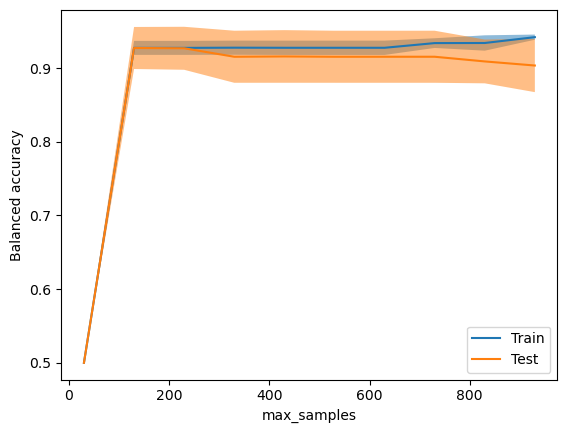

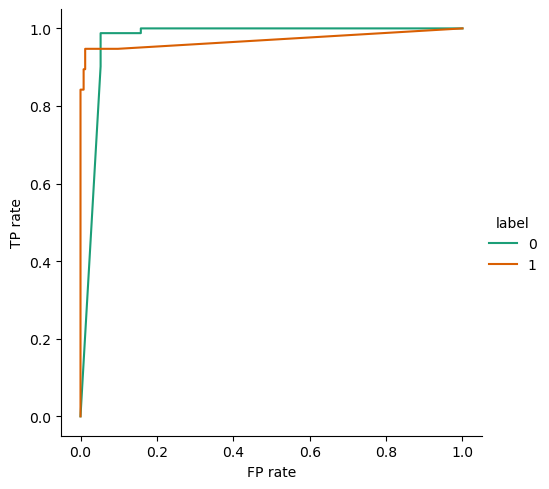

In [88]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split, validation_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
import numpy as np
from sklearn.metrics import balanced_accuracy_score
import seaborn as sns
from sklearn.metrics import roc_curve
from sklearn.model_selection import ValidationCurveDisplay
#split the data into features and target
X = elo[['quality', 'importance', 'total_rating', 'elo1_pre', 'elo2_pre']]
y = elo['playoff']
#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=302)
#grid search for kNN and Decision Tree
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
tree = DecisionTreeClassifier(random_state=19716)
knn_params = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance']
}
tree_params = {
    'max_depth': [6, 8, 10, 12, 14, 16],
    'min_samples_leaf': [1, 4, 7]
}
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=302)
knn_gs = GridSearchCV(knn, knn_params, cv=cv, scoring='balanced_accuracy')
tree_gs = GridSearchCV(tree, tree_params, cv=cv, scoring='balanced_accuracy')
knn_gs.fit(X_train, y_train)
tree_gs.fit(X_train, y_train)
#Using the best decision tree to find the feature importances
best_tree = tree_gs.best_estimator_
feature_importances = best_tree.feature_importances_
feature_importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
print(feature_importances_df)
#Using an ensemble method with training data 
pipe = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=3))
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
ensemble = BaggingClassifier(
    pipe,
    max_samples=0.1,
    n_estimators=30,
    random_state=302
)
ensemble.fit(X_train, y_train)
#making a validation curve as a function of the max ensemble sample size
#alpha = np.linspace(0.04, 1.0, 10)
#_,val = validation_curve(ensemble, X_train, y_train, cv=cv, param_name='max_samples', param_range=alpha, n_jobs=-1, scoring='balanced_accuracy')
#sns.relplot(x=alpha, y=np.mean(val, axis=1))

ValidationCurveDisplay.from_estimator(
    ensemble, X, y, param_name='max_samples', param_range=range(30, 1000, 100), cv=cv, scoring='balanced_accuracy', n_jobs=-1
)
#Comparing the classifiers and making an ROC curve for the best performer
knn_pred = knn_gs.best_estimator_.predict(X_test)
tree_pred = tree_gs.best_estimator_.predict(X_test) 
ensemble_pred = ensemble.predict(X_test)

knn_balanced_accuracy = balanced_accuracy_score(y_test, knn_pred)
tree_balanced_accuracy = balanced_accuracy_score(y_test, tree_pred)
ensemble_balanced_accuracy = balanced_accuracy_score(y_test, ensemble_pred)

classifiers = {'KNN': knn_balanced_accuracy, 'Decision Tree': tree_balanced_accuracy, 'Ensemble': ensemble_balanced_accuracy}
print(classifiers)
best_classifier = max(classifiers, key=classifiers.get)
print(f'The best classifier is {best_classifier} with a balanced accuracy of {classifiers[best_classifier]}')

p_hat = ensemble.predict_proba(X_test)
results = []
for i, label in enumerate(ensemble.classes_):
    actual = (y_test == label)
    fp, tp, theta = roc_curve(actual, p_hat[:, i])
    results.extend([(label, fp, tp) for fp, tp in zip(fp, tp)])

roc = pd.DataFrame(results, columns=["label", "FP rate", "TP rate"])

import seaborn as sns
sns.relplot(data=roc, 
    x="FP rate", y="TP rate", 
    hue="label", kind="line", estimator=None,
    palette="Dark2"
)




# Regression
Task: Predict the importance score of a game using the elo of the 2 teams before the game, the elo probability of each team, the raptor of the 2 teams before the game, the raptor probability of each team, and whether or not it was a playoff game.

The quantitative target column is 'importance' and the potential features are 'elo1_pre', 'elo2_pre', 'elo_prob1', 'elo_prob2', 'raptor_prob1', 'raptor_prob2', 'raptor1_pre', 'raptor2_pre', and 'playoff'. I will be using the coefficient of determination for scoring.




/Users/brendonuzoigwe/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Best alpha: 0.1
        Feature  Coefficient
1      elo2_pre    50.181449
2     elo_prob1    38.299250
8       playoff    11.488962
6   raptor1_pre    10.786430
5  raptor_prob2     4.585185
7   raptor2_pre     3.930562
4  raptor_prob1    -4.585185
3     elo_prob2   -38.299250
0      elo1_pre   -56.974018
Dropped features: ['elo_prob2' 'raptor_prob2']
Ridge R^2: 0.38468378496765077
Lasso R^2: 0.3845741883682805
KNN R^2: 0.68921322600456


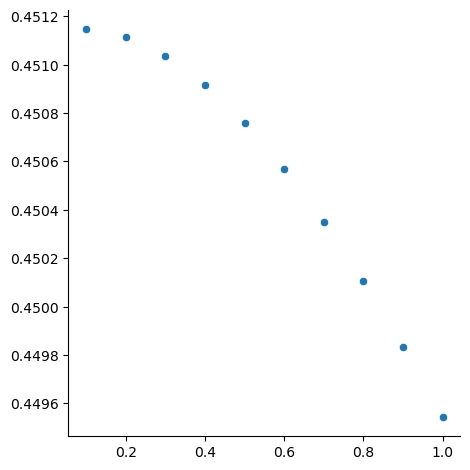

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
#split the data into features and target
X = elo[['elo1_pre', 'elo2_pre', 'elo_prob1', 'elo_prob2', 'raptor_prob1', 'raptor_prob2', 'raptor1_pre', 'raptor2_pre', 'playoff']]
y = elo['importance']
#standardizing the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=2)
#Using Ridge regression on the standardized data
ridge = Ridge(alpha=0.1)
ridge.fit(X_train, y_train)
alpha = np.linspace(.1, 1, 10)
#Using a validation curve to find the best alpha
_,v = validation_curve(ridge, X_train, y_train, cv=3, param_name='alpha', param_range=alpha, scoring='r2')
sns.relplot(x=alpha, y=np.mean(v, axis=1))
best_alpha = alpha[np.argmax(np.mean(v, axis=1))]
print("Best alpha:", best_alpha)
#showing which columns have the most influence on the target
coefficients = ridge.coef_
coefficients_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': coefficients})
coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)
print(coefficients_df)
#Using LASSO regression with a regularization value that zeros out at least two of the weights
lass = Lasso(alpha=0.05)
lass.fit(X_train, y_train)
pd.DataFrame({'Feature': X.columns, 'Coefficient': lass.coef_}).sort_values(by='Coefficient', ascending=False)
zeroed = np.nonzero( np.abs(lass.coef_) < 1e-5 )
dropped = X.columns[zeroed].values
#Showing which columns were dropped
print("Dropped features:", dropped)
#Using a grid search for kNN regression and comparing the R^2 values of the three models
knn_params2 = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance']
}
knn2 = KNeighborsRegressor()
knn2.fit(X_train, y_train)
knn_gs2 = GridSearchCV(knn2, knn_params2, cv=3, scoring='r2')
knn_gs2.fit(X_train, y_train)

ridge_score = ridge.score(X_test, y_test)
lasso_score = lass.score(X_test, y_test)
knn_score = knn_gs2.best_estimator_.score(X_test, y_test)
print("Ridge R^2:", ridge_score)
print("Lasso R^2:", lasso_score)
print("KNN R^2:", knn_score)




# Discussion

For classification, the ensemble method was the best with a score of 92.1% balanced accuracy which is pretty good. The kNN and decision tree classifiers weren't to bad either with a score of 86.8% and 86.6% respectively. For regression, kNN was the best method with 0.689 R^2 which is decent, but still leaves something to be desired. The ridge and lasso methods did not perform very well both having an R^2 value of about 0.385

The most relevant feature of the dataset for classification was total rating and the least relevant features were the elo of team 1 before the game and the importance of the game. The most relevant features of the dataset for regression were the elo of both teams before the game. The least relavant features were the raptor score of team 2 before the game and the raptor probability for both teams.

Some additional features that could be helpful to the results are the records for team1 and team2 at the time of the game for regression and crowd attendance of team1 and team2 for classification.